In [ ]:
import numpy as np
import pandas as pd
from numpy import array
from math import sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

from pyspark.sql.functions import col


In [ ]:
spark.version
sqlContext = SQLContext(sc)
batting=sqlContext.read.csv("stats_batting_2.csv", header=True, mode="DROPMALFORMED")
bowling=sqlContext.read.csv("stats_bowling_1 .csv", header=True, mode="DROPMALFORMED")
bowling.show()
batting.show()

In [13]:
batting.na.drop()
bowling=bowling.na.drop()

FEATURES_COL=["runs_scored","balls_faced","times_out","batting_average","strike_rate"]
FEATURES_COL_BOWL=["runs_conceded","wickets_taken","overs_bowled","bowling_average","economy_rate","bowling_strike_rate"]

# df_feat = batting.select(*(batting[c].cast("float").alias(c) for c in batting.columns[1:]))
# df_feat_bowl = bowling.select(*(bowling[c].cast("float").alias(c) for c in bowling.columns[1:]))

# df_feat_bowl.show()
# df_feat.show()

In [14]:
for col in batting.columns:
    if col in FEATURES_COL:
        batting = batting.withColumn(col,batting[col].cast('float'))
batting.show()

for col in bowling.columns:
    if col in FEATURES_COL_BOWL:
        bowling = bowling.withColumn(col,bowling[col].cast('float'))
bowling.show()

+---------------+-----------+-----------+---------+---------------+-----------+
|    player_name|runs_scored|balls_faced|times_out|batting_average|strike_rate|
+---------------+-----------+-----------+---------+---------------+-----------+
| A Ashish Reddy|      280.0|      193.0|     15.0|          18.67|     145.08|
|       A Chopra|       53.0|       71.0|      6.0|           8.83|      74.65|
|    A Choudhary|       25.0|       20.0|      1.0|           25.0|      125.0|
|     A Flintoff|       62.0|       53.0|      2.0|           31.0|     116.98|
|       A Kumble|       35.0|       47.0|      3.0|          11.67|      74.47|
|       A Mishra|      341.0|      365.0|     29.0|          11.76|      93.42|
|       A Mithun|       34.0|       26.0|      5.0|            6.8|     130.77|
|       A Mukund|       19.0|       22.0|      2.0|            9.5|      86.36|
|        A Nehra|       41.0|       62.0|      7.0|           5.86|      66.13|
|        A Singh|        2.0|       10.0

In [15]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(batting).select('player_name', 'features')
df_kmeans.show()

vecAssembler_bowl = VectorAssembler(inputCols=FEATURES_COL_BOWL, outputCol="features_bowl")
df_kmeans_bowl = vecAssembler_bowl.transform(bowling).select('player_name', 'features_bowl')
df_kmeans_bowl.show()


+---------------+--------------------+
|    player_name|            features|
+---------------+--------------------+
| A Ashish Reddy|[280.0,193.0,15.0...|
|       A Chopra|[53.0,71.0,6.0,8....|
|    A Choudhary|[25.0,20.0,1.0,25...|
|     A Flintoff|[62.0,53.0,2.0,31...|
|       A Kumble|[35.0,47.0,3.0,11...|
|       A Mishra|[341.0,365.0,29.0...|
|       A Mithun|[34.0,26.0,5.0,6....|
|       A Mukund|[19.0,22.0,2.0,9....|
|        A Nehra|[41.0,62.0,7.0,5....|
|        A Singh|[2.0,10.0,4.0,0.5...|
|      A Symonds|[974.0,750.0,27.0...|
|       A Uniyal|[4.0,7.0,1.0,4.0,...|
|        A Zampa|[5.0,8.0,2.0,2.5,...|
|    AA Bilakhia|[69.0,85.0,5.0,13...|
|      AA Chavan|[12.0,11.0,2.0,6....|
|AA Jhunjhunwala|[217.0,210.0,13.0...|
|      AA Noffke|[9.0,10.0,1.0,9.0...|
|     AB Agarkar|[179.0,154.0,10.0...|
|      AB Barath|[42.0,42.0,2.0,21...|
|       AB Dinda|[26.0,48.0,10.0,2...|
+---------------+--------------------+
only showing top 20 rows

+---------------+--------------------+

In [16]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later

cost_bowl = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features_bowl")
    model = kmeans.fit(df_kmeans_bowl.sample(False,0.1, seed=42))
    cost_bowl[k] = model.computeCost(df_kmeans_bowl) # requires Spark 2.0 or later

Text(0,0.5,'cost_bowl')

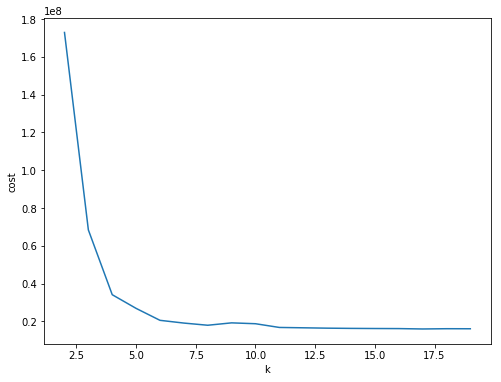

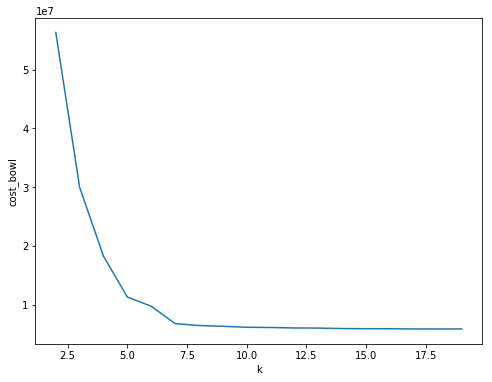

In [17]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost_bowl[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost_bowl')

In [19]:
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

k = 7
kmeans_bowl = KMeans().setK(k).setSeed(1).setFeaturesCol("features_bowl")
model_bowl = kmeans_bowl.fit(df_kmeans_bowl)
centers_bowl = model_bowl.clusterCenters()

print("Cluster Centers: ")
for center in centers_bowl:
    print(center)


Cluster Centers: 
[26.76595745 28.29787234  3.02553191  9.32131916 86.59697882]
[2625.93333333 2023.66666667   91.86666667   29.05933317  130.13333282]
[4808.66666667 3604.66666667  138.33333333   34.87000084  133.40666199]
[685.04       524.08        30.28        24.13400013 131.89520142]
[1418.69230769 1119.           52.61538462   27.90000006  127.76153917]
[3912.11111111 2923.66666667  114.33333333   34.89888869  134.46444448]
[1824.18181818 1446.36363636   63.           29.72999972  126.26181932]
[149.8372093  127.11627907   8.95348837  19.03976735 120.20372107]
[1031.31818182  794.95454545   37.18181818   28.94727273  130.23409167]
[360.95555556 298.73333333  19.53333333  20.25044452 121.43955621]
Cluster Centers: 
[117.5          3.71641791  13.7977612   38.28671639   8.68417907
  25.68388058]
[3478.4         129.2         455.95999756   27.59199982    7.66999989
   21.67400017]
[947.85714286  32.24489796 118.9510196   30.44040812   7.98244902
  22.90040812]
[1646.9          59.

In [20]:
transformed = model.transform(df_kmeans).select('player_name', 'prediction')
rows = transformed.collect()
print(rows[:3])

transformed = model_bowl.transform(df_kmeans_bowl).select('player_name', 'prediction')
rows_bowl = transformed.collect()
print(rows_bowl[:3])

[Row(player_name=u'A Ashish Reddy', prediction=9), Row(player_name=u'A Chopra', prediction=0), Row(player_name=u'A Choudhary', prediction=0)]
[Row(player_name=u'A Ashish Reddy', prediction=4), Row(player_name=u'A Chandila', prediction=0), Row(player_name=u'A Choudhary', prediction=0)]


In [23]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

df_pred_bowl = sqlContext.createDataFrame(rows_bowl)
df_pred_bowl.show()

+---------------+----------+
|    player_name|prediction|
+---------------+----------+
| A Ashish Reddy|         9|
|       A Chopra|         0|
|    A Choudhary|         0|
|     A Flintoff|         0|
|       A Kumble|         0|
|       A Mishra|         9|
|       A Mithun|         0|
|       A Mukund|         0|
|        A Nehra|         0|
|        A Singh|         0|
|      A Symonds|         8|
|       A Uniyal|         0|
|        A Zampa|         0|
|    AA Bilakhia|         0|
|      AA Chavan|         0|
|AA Jhunjhunwala|         7|
|      AA Noffke|         0|
|     AB Agarkar|         7|
|      AB Barath|         0|
|       AB Dinda|         0|
+---------------+----------+
only showing top 20 rows

+---------------+----------+
|    player_name|prediction|
+---------------+----------+
| A Ashish Reddy|         4|
|     A Chandila|         0|
|    A Choudhary|         0|
|     A Flintoff|         0|
|       A Kumble|         2|
|       A Mishra|         1|
|       A Mithun|

In [39]:
bat_cluster=df_pred.toPandas()
bat_cluster.to_csv("/home/gajendra/Documents/Big_Data/Project/batting_cluster.csv")

bowl_cluster=df_pred_bowl.toPandas()
bowl_cluster.to_csv("/home/gajendra/Documents/Big_Data/Project/bowling_cluster.csv")


In [50]:
# df_pred = df_pred.join(batting, 'player_name')
# df_pred_bowl = df_pred_bowl.join(bowling, 'player_name')
df_pred.show()
df_pred_bowl.show()


+---------------+----------+-----------+-----------+---------+---------------+-----------+
|    player_name|prediction|runs_scored|balls_faced|times_out|batting_average|strike_rate|
+---------------+----------+-----------+-----------+---------+---------------+-----------+
| A Ashish Reddy|         9|      280.0|      193.0|     15.0|          18.67|     145.08|
|       A Chopra|         0|       53.0|       71.0|      6.0|           8.83|      74.65|
|    A Choudhary|         0|       25.0|       20.0|      1.0|           25.0|      125.0|
|     A Flintoff|         0|       62.0|       53.0|      2.0|           31.0|     116.98|
|       A Kumble|         0|       35.0|       47.0|      3.0|          11.67|      74.47|
|       A Mishra|         9|      341.0|      365.0|     29.0|          11.76|      93.42|
|       A Mithun|         0|       34.0|       26.0|      5.0|            6.8|     130.77|
|       A Mukund|         0|       19.0|       22.0|      2.0|            9.5|      86.36|

In [40]:
# pddf_pred = df_pred.toPandas().set_index('player_name')
# pddf_pred.to_csv("/home/gajendra/Documents/Big_Data/Project/stats_batting_prediction.csv")

In [61]:
batting_prob=sqlContext.read.csv("/home/gajendra/r_prob.csv", header=True, mode="DROPMALFORMED")
bowling_prob=sqlContext.read.csv("/home/gajendra/wicket.csv",header=True,mode="DROPMALFORMED")
# batting_prob.show()
# bowling_prob.show()


In [52]:
batting_prob_clus=batting_prob.join(df_pred_bowl,df_pred_bowl.player_name==batting_prob.bowler,'leftouter').select(batting_prob["*"],df_pred_bowl["prediction"])

batting_prob_clus=batting_prob_clus.selectExpr("_c0 as index","batsman as batsman","bowler as bowler","P0 as P0","P1 as P1","P2 as P2","P3 as P3","P4 as P4","P6 as P6","prediction as bowler_cluster")
batting_prob_clus=batting_prob_clus.join(df_pred,df_pred.player_name==batting_prob_clus.batsman,'leftouter').select(batting_prob_clus["*"],df_pred["prediction"])
batting_prob_clus=batting_prob_clus.selectExpr("index as index","batsman as batsman","bowler as bowler","P0 as P0","P1 as P1","P2 as P2","P3 as P3","P4 as P4","P6 as P6","bowler_cluster as bowler_cluster","prediction as batsman_cluster")


bowling_prob_clus=bowling_prob.join(df_pred_bowl,df_pred_bowl.player_name==bowling_prob.bowler,'leftouter').select(bowling_prob["*"],df_pred_bowl["prediction"])
bowling_prob_clus=bowling_prob_clus.selectExpr("_c0 as index","batsman as batsman","bowler as bowler","no_of_times as no_of_times","no_of_balls as no_of_balls","p_out as p_out","p_not_out as p_not_out","prediction as bowler_cluster")
bowling_prob_clus=bowling_prob_clus.join(df_pred,df_pred.player_name==bowling_prob_clus.batsman,'leftouter').select(bowling_prob_clus["*"],df_pred["prediction"])
bowling_prob_clus=bowling_prob_clus.selectExpr("index as index","batsman as batsman","bowler as bowler","no_of_times as no_of_times","no_of_balls as no_of_balls","p_out as p_out","p_not_out as p_not_out","bowler_cluster as bowler_cluster","prediction as batsman_cluster")
batting_prob_clus.show()
# bowling_prob_clus.show()
# pddf_pred = bowling_prob_clus.toPandas()
# pddf_pred1 = bowling_prob.toPandas()
# print(pddf_pred.shape)
# print(pddf_pred1.shape)
# print(pddf_pred)


+-----+-------------+---------------+-----------------+-----------------+-----------------+---+-----------------+-----------------+--------------+---------------+
|index|      batsman|         bowler|               P0|               P1|               P2| P3|               P4|               P6|bowler_cluster|batsman_cluster|
+-----+-------------+---------------+-----------------+-----------------+-----------------+---+-----------------+-----------------+--------------+---------------+
| 7726|Kuldeep Yadav|      S Aravind|                1|                0|                0|  0|                0|                0|             2|              0|
| 7727|Kuldeep Yadav|     TG Southee|              0.2|              0.4|                0|  0|              0.4|                0|             2|              0|
| 7723|Kuldeep Yadav|      HH Pandya|0.333333333333333|0.666666666666667|                0|  0|                0|                0|             2|              0|
| 7728|Kuldeep Yadav| 

In [54]:
pd_bowling_prob=bowling_prob_clus.toPandas()
pd_batting_prob=batting_prob_clus.toPandas()

In [55]:
pd_batting_prob.to_csv("/home/gajendra/Documents/Big_Data/Project/pd_batting_prob.csv")
pd_bowling_prob.to_csv("/home/gajendra/Documents/Big_Data/Project/pd_bowling_prob.csv")


In [56]:
df=pd.read_csv('/home/gajendra/Documents/Big_Data/Project/pd_batting_prob.csv')
df2=pd.read_csv('/home/gajendra/Documents/Big_Data/Project/pd_bowling_prob.csv')


In [57]:
#res=df.groupby(['player_out','bowler'])['wicket_kind'].count().reset_index(name='number_of_times')
res = df.groupby(["bowler_cluster","batsman_cluster"])['P0','P1','P2','P3','P4','P6'].mean().round(2).reset_index()
res2 = df2.groupby(["bowler_cluster","batsman_cluster"])['p_not_out'].mean().round(2).reset_index()

In [58]:
ref = df.groupby(["batsman","bowler"])['P0','P1','P2','P3','P4','P6'].mean().round(2).reset_index()
ref2 = df2.groupby(["batsman","bowler"])['p_not_out'].mean().round(2).reset_index()

In [59]:
final_ref=ref
final_ref=final_ref.merge(ref2,how='outer',left_on=["batsman","bowler"],right_on=["batsman","bowler"])

In [60]:
final=res
final['p_not_out']=res2['p_not_out']

In [63]:
final_ref.to_csv('pp_prob.csv',index=None)
final.to_csv('clusters_prob.csv',index=None)

In [85]:
#--------------------------